In [1]:
%matplotlib inline
import ipymd

In [2]:
data = ipymd.md_data.LAMMPS_Data(
    sys_path=ipymd.get_test_path('system.dump'),
    atom_path=ipymd.get_test_path(['atom_dump','atoms_*.dump']))

In [3]:
sys_data = data.get_system_data()
sys_data.tail()

,time,natoms,a,b,vol,press,temp,peng,keng,teng,enth
94,18800,5880,4.000919,4.000920,106961.684112,3984.476256,20.821004,-576758.385663,364.871078,-576393.514586,-570178.024689
95,19000,5880,4.002667,4.002667,107055.104770,3457.822223,20.543535,-576743.788115,360.008650,-576383.779465,-570985.120033
96,19200,5880,3.995696,3.995696,106682.545808,1880.020740,14.949236,-576635.072775,261.973143,-576373.099632,-573448.059018
97,19400,5880,3.990131,3.990134,106385.666301,499.341106,21.315529,-576735.710976,373.537223,-576362.173753,-575587.433134
98,19600,5880,3.979611,3.979609,105825.294988,-2300.315883,17.161320,-576652.409368,300.738098,-576351.671270,-579901.871560


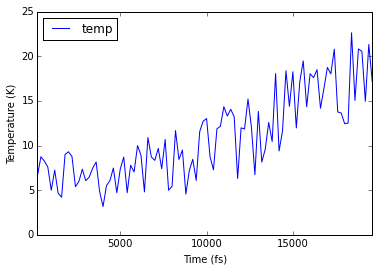

In [4]:
ax = sys_data.plot('time','temp')
ax.set_xlabel('Time (fs)')
ax.set_ylabel('Temperature (K)');

In [5]:
print data.get_atom_timestep(98)
atom_data = data.get_atom_data(98)
sim_box = data.get_simulation_box(98)
atom_data.head()

9800


,id,type,xs,ys,zs,mass,q
0,259,1,-27.857561,-21.882633,7.196651,55.845,-1.505560e-07
1,267,1,-27.861259,-25.857124,7.188060,55.845,-2.182330e-07
2,269,1,-25.863859,-23.880771,7.181207,55.845,-2.916280e-07
3,271,1,-23.879500,-21.886533,7.184821,55.845,-2.084570e-07
4,279,1,-25.866796,-27.853247,7.182366,55.845,-1.888220e-07


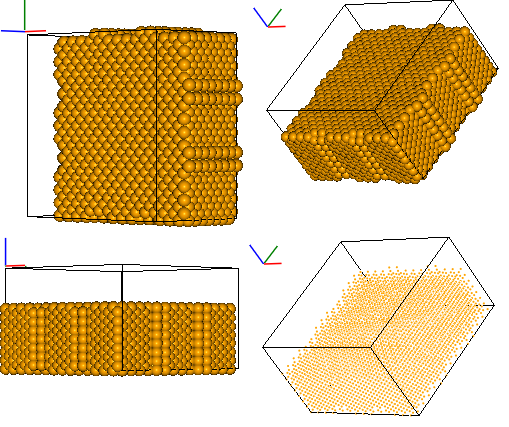

In [6]:
vis = ipymd.visualise_sim.Visualise_Sim()

images = [vis.get_image(atom_data,sim_box,type_dict={1:'Fe'},
         xrot=xrot,yrot=45) for xrot in [0,45,90]]
images.append(vis.get_image(atom_data,sim_box,type_dict={1:'Fe'},
                        xrot=45,yrot=45,spheres=False))
vis.visualise(images, columns=2)